In [1]:
#LES-5 DC-to-DC solar converter data summary

import struct
import datetime
import numpy as np
import os
import matplotlib.pyplot as plt

# uncomment this command below to display the DC-to-DC converter channels so you can zoom into and measure data.
#%matplotlib qt


In [2]:
#open data file and determine the file lenght in bytes
#concatenate all of the pass#_data into les5_data...

with open("les5_data", "rb") as binary_file:
    # Read the whole file at once
    byte_range = binary_file.read() 
    
file_length_in_bytes = os.path.getsize("les5_data")
frame_count = int(file_length_in_bytes/36)
print(frame_count)

892994


In [3]:
#create a numpy array of UNIX timestamps

ts = 0
ts_i = 0
time_stamps = np.arange(frame_count).reshape(frame_count,1)

while ts < frame_count: 
    time_stamps[ts] = struct.unpack('<I', byte_range[ts_i:ts_i+4])
    ts_i = ts_i + 36
    ts = ts + 1  
    
t = time_stamps.astype('datetime64[s]')

In [4]:
# Create numpy array of data frames, 32 bytes per frame.  
# For LES-5 there are 32 Words (bytes) per Frame.

byte_count = 4
frame = 0
frame_words = np.arange(frame_count*32).reshape(frame_count,32)

while frame < frame_count:
    for x in range (0,32):
        frame_words[frame,x] = byte_range[byte_count+x]
    frame = frame + 1
    byte_count = (frame * 36) + 4

In [5]:
# Display the Timestamp and Frame Words

myframe = 0

print(datetime.datetime.utcfromtimestamp(time_stamps[myframe]))
print(datetime.datetime.utcfromtimestamp(time_stamps[frame_count-1]))

frame_words[myframe]


2020-04-13 08:03:30
2020-07-02 14:55:22


array([ 73, 136,  76,  32,   0,  23,   1, 254, 145,   0, 202, 182, 188,
       159,   0, 179, 178, 179, 254,   0,  93,  85,   0, 214,   0, 184,
       188, 192,   0,   0, 249,  28])

In [6]:
#Even frames have 01001001 in word 0 and 00011100 in word 31, while odd frames have the inverted patterns (10110110 in word 0 and 11100011 in word 31).

print("{0:08b}".format((frame_words[myframe,0])))
print("{0:08b}".format((frame_words[myframe,31])))

01001001
00011100


In [7]:
#The frame numbering, in the case of LES-5, can be obtained from the value of word 2. The LESTR-2 report mentions that a value of 01000000 in this word indicates frame 0. However, from looking at the data, we see that indeed the frame number can be obtained from bits 4 and 5 in this word, which form a binary counter than counts up from 0 to 3.
#The frame counter cycles through a 2-bit binary sequence, just as expected. Looking at the word immediately after the frame counter, it would appear that the check word that they mentioned is just the current frame count plus one. At first, I was completely surprised that this was the check word, because in other satellites I’ve looked at, it’s usually some form of CRC checksum.
print("Frame Count")
print("{0:08b}".format((frame_words[myframe,2])))
print("{0:08b}".format((frame_words[myframe+1,2])))
print("{0:08b}".format((frame_words[myframe+2,2])))
print("{0:08b}".format((frame_words[myframe+3,2])))
print("Check Frames")
print("{0:08b}".format((frame_words[myframe,3])))
print("{0:08b}".format((frame_words[myframe+1,3])))
print("{0:08b}".format((frame_words[myframe+2,3])))
print("{0:08b}".format((frame_words[myframe+3,3])))



Frame Count
01001100
01000000
01000100
01001000
Check Frames
00100000
00100100
00101000
00101010


In [8]:
# the start of a group can be recognised because word 7 in frame 0 has the value 11110100.
x = 0
for x in range (0,128):
    print(x, "{0:08b}".format((frame_words[myframe+x,7])))
    if frame_words[myframe+x,7] == 244:
        print("Start of Group at", myframe+x)   

0 11111110
1 11001111
2 10010100
3 10101001
4 11111110
5 11000110
6 10010100
7 10100111
8 11111110
9 10111001
10 10010100
11 10100000
12 11111110
13 10110001
14 10010100
15 10011111
16 11111110
17 10101000
18 11111110
19 10100000
20 11111110
21 10011011
22 10010100
23 10010111
24 11111110
25 10010100
26 10010000
27 11111110
28 10000011
29 10010100
30 10001110
31 11111110
32 11110100
Start of Group at 32
33 11111110
34 11101100
35 10010100
36 10001011
37 11100110
38 11010111
39 11111110
40 11000110
41 11111110
42 10110000
43 10010100
44 01110101
45 11111110
46 10101000
47 10010100
48 11111110
49 10100000
50 10010100
51 01101110
52 11111110
53 10011011
54 10010100
55 01101101
56 11111110
57 10010011
58 11111110
59 10000011
60 10010100
61 01100100
62 11111110
63 11110100
Start of Group at 63
64 10010100
65 11111110
66 11101100
67 10010100
68 10111000
69 10010100
70 11111110
71 11111111
72 11011111
73 10010100
74 11111100
75 11111110
76 11010111
77 00010100
78 11111011
79 11111110
80 11001

In [9]:
# masking the frame counter bits in Word 2, bits 4 and 5.
result = frame_words[myframe+3,2] & 12
result

8

In [10]:
FRAME_COUNT_MASK = 12
frame0_count = 0 
frame1_count = 0
frame2_count = 0
frame3_count = 0

for x in range (0,frame_count):
        if frame_words[x,2] & FRAME_COUNT_MASK == 0:
            frame0_count = frame0_count + 1
        if frame_words[x,2] & FRAME_COUNT_MASK == 4:
            frame1_count = frame1_count + 1
        if frame_words[x,2] & FRAME_COUNT_MASK == 8:
            frame2_count = frame2_count + 1
        if frame_words[x,2] & FRAME_COUNT_MASK == 12:
            frame3_count = frame3_count + 1   
            

frame0_words = np.arange(frame0_count*32).reshape(frame0_count,32)
frame1_words = np.arange(frame1_count*32).reshape(frame1_count,32)
frame2_words = np.arange(frame2_count*32).reshape(frame2_count,32)
frame3_words = np.arange(frame3_count*32).reshape(frame3_count,32)

frame0_timestamps = np.arange(frame0_count*32).reshape(frame0_count,32)
frame1_timestamps = np.arange(frame1_count*32).reshape(frame1_count,32)
frame2_timestamps = np.arange(frame2_count*32).reshape(frame2_count,32)
frame3_timestamps = np.arange(frame3_count*32).reshape(frame3_count,32)

frame = 0
frame0_count = 0
frame1_count = 0
frame2_count = 0
frame3_count = 0

while frame < frame_count:
    if frame_words[frame,2] & FRAME_COUNT_MASK == 0: 
        for x in range (0,32):
            frame0_words[frame0_count,x] = frame_words[frame,x]
            frame0_timestamps[frame0_count] = time_stamps[frame]
        #print("FRAME 0:",frame, frame0_cnt, frame0_words[frame0_cnt,x],frame_words[frame,x])
        frame0_count = frame0_count + 1
    
    if frame_words[frame,2] & FRAME_COUNT_MASK == 4: 
        for x in range (0,32):
            frame1_words[frame1_count,x] = frame_words[frame,x]
            frame1_timestamps[frame1_count] = time_stamps[frame]
        #print("FRAME 1:",frame, frame1_cnt, frame1_words[frame1_cnt,x],frame_words[frame,x])
        frame1_count = frame1_count + 1    
    
    if frame_words[frame,2] & FRAME_COUNT_MASK == 8: 
        for x in range (0,32):
            frame2_words[frame2_count,x] = frame_words[frame,x]
            frame2_timestamps[frame2_count] = time_stamps[frame]
        #print("FRAME 2:",frame, frame2_cnt, frame2_words[frame2_cnt,x],frame_words[frame,x])
        frame2_count = frame2_count + 1    
        
    if frame_words[frame,2] & FRAME_COUNT_MASK == 12: 
        for x in range (0,32):
            frame3_words[frame3_count,x] = frame_words[frame,x]
            frame3_timestamps[frame3_count] = time_stamps[frame]
        #print("FRAME 3:",frame, frame3_cnt, frame3_words[frame3_cnt,x],frame_words[frame,x])
        frame3_count = frame3_count + 1 
    
    frame = frame + 1    

t0 = frame0_timestamps.astype('datetime64[s]')
t1 = frame1_timestamps.astype('datetime64[s]')
t2 = frame2_timestamps.astype('datetime64[s]')    
t3 = frame3_timestamps.astype('datetime64[s]')
           

In [11]:
#Full pass LES-5 telemetry data summary

X = 15
Y = 5
MARKERSIZE = .01
ALPHA = .5
SYNC_COLOR = 'red'
DATA_WORD_COLOR = 'blue'
ERROR_DETECTION_WORD_COLOR = 'green'
RFI_EXPERIEMNT_DATA_COLOR = 'orange'
ZOOMED_DATA_WORD_COLOR = 'violet'

In [12]:
#FRAME 1 data words
x = 0


frame1_word_12 = np.arange(frame1_count).reshape(frame1_count,1)

frame1_word_27 = np.arange(frame1_count).reshape(frame1_count,1)

for x in range (0,frame1_count):
    frame1_word_12[x] = frame1_words[x,12]
    frame1_word_27[x] = frame1_words[x,27]
    

In [13]:
#FRAME 2 data words
x = 0


frame2_word_17 = np.arange(frame2_count).reshape(frame2_count,1)

for x in range (0,frame2_count):
    frame2_word_17[x] = frame2_words[x,17]
    
    

In [14]:
#FRAME 3 data words
x = 0


frame3_word_27 = np.arange(frame3_count).reshape(frame3_count,1)


for x in range (0,frame3_count):
    frame3_word_27[x] = frame3_words[x,27]
   

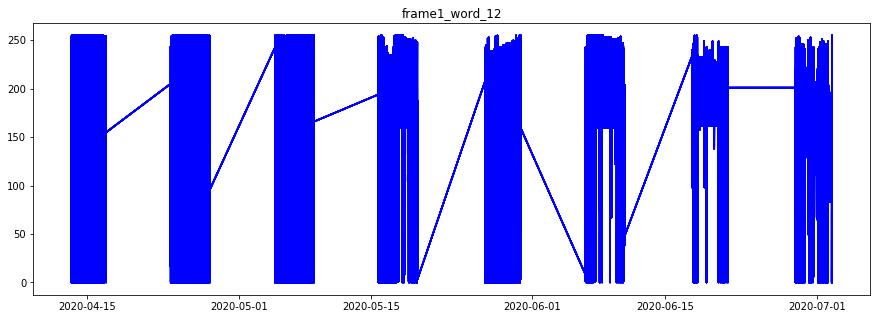

In [15]:
plt.figure(figsize = [X,Y])
plt.title('frame1_word_12')
plt.plot(t1, frame1_word_12, markersize=MARKERSIZE, alpha=ALPHA, color=DATA_WORD_COLOR);


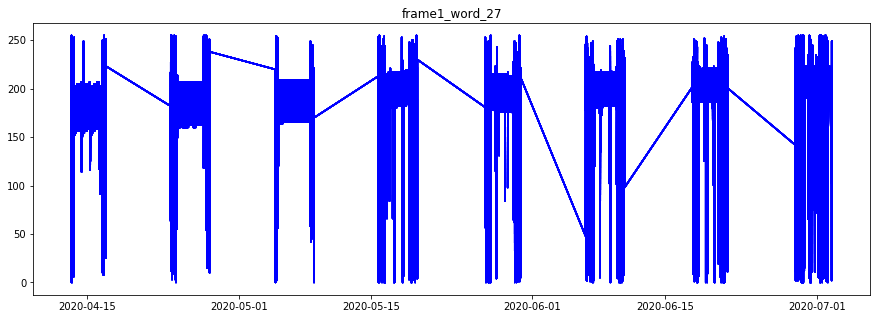

In [16]:
plt.figure(figsize = [X,Y])
plt.title('frame1_word_27')
plt.plot(t1, frame1_word_27, markersize=MARKERSIZE, alpha=ALPHA, color=DATA_WORD_COLOR);


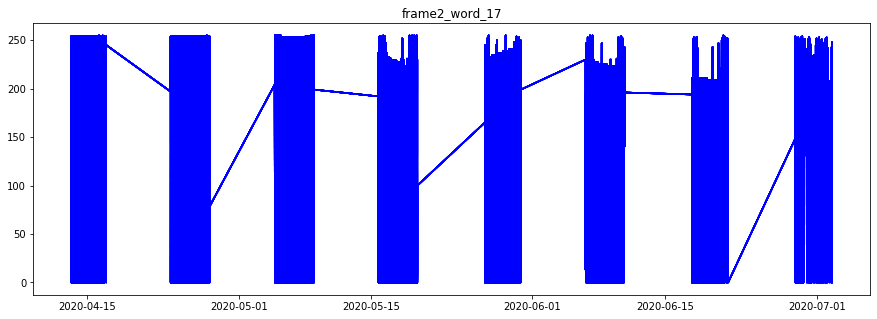

In [17]:
plt.figure(figsize = [X,Y])
plt.title('frame2_word_17')
plt.plot(t2, frame2_word_17, markersize=MARKERSIZE, alpha=ALPHA, color=DATA_WORD_COLOR);


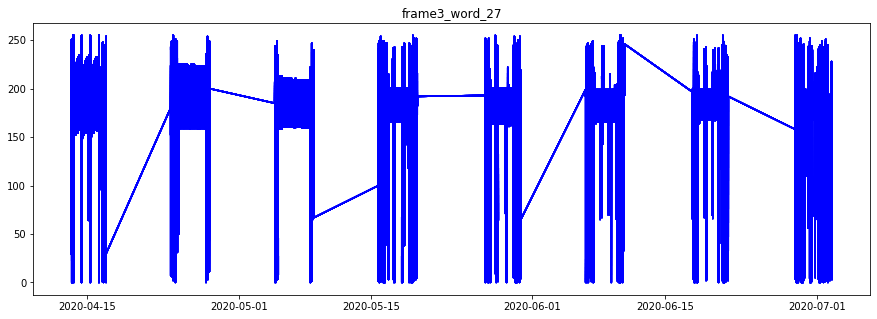

In [18]:
plt.figure(figsize = [X,Y])
plt.title('frame3_word_27')
plt.plot(t3, frame3_word_27, markersize=MARKERSIZE, alpha=ALPHA, color=DATA_WORD_COLOR);
